## Loading dependencies

In [34]:
using LazySets           # for set computations
using Symbolics          # for symbolics computations
using Plots              # for plotting
using IntervalArithmetic # for computations with intervals

using LazySets: center,   # fix an ambiguity between LazySets and Plots
                Interval  # fix an ambiguity between LazySets and IntervalArithmetic 

using ReachabilityAnalysis # for reachability analysis

# load stuff that allows using symbolic / numeric differentiation
using ReachabilityAnalysis: _jacobian_expression, _jacobian_function,
                            _hessian_expression, _hessian_function

## Running example: Lotka-Volterra equations

In [2]:
function lotkavolterra!(dx, x, params, t)
    local α, β, γ, δ = 1.5, 1., 3., 1.
    
    dx[1] = α * x[1] - β * x[1] * x[2]
    dx[2] = δ * x[1] * x[2] - γ * x[2]
    
    return dx
end

lotkavolterra! (generic function with 1 method)

In [3]:
params = []
t = 0.0
x0 = [1.0, 1.0] # initial states
dx = [0.0, 0.0] # right-hand side

# this call will store the evaluation of the right-hand side
# on the vector dx
lotkavolterra!(dx, x0, params, t)

2-element Vector{Float64}:
  0.5
 -2.0

In [4]:
dx

2-element Vector{Float64}:
  0.5
 -2.0

In [5]:
# for example
α, β, γ, δ = 1.5, 1., 3., 1.
α * x0[1] - β * x0[1] * x0[2]

0.5

In [6]:
δ * x0[1] * x0[2] - γ * x0[2]

-2.0

## Splitting boxes

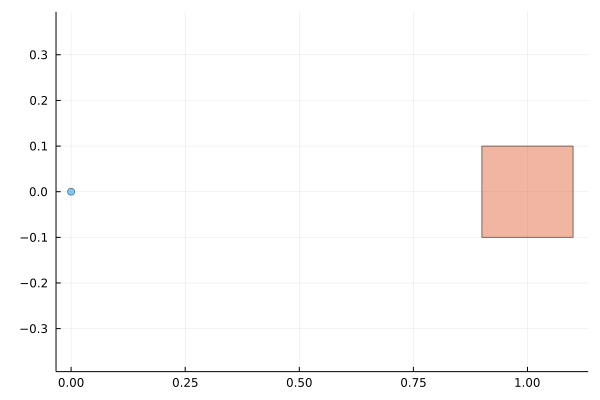

In [7]:
# definition of a box in terms of outer and inner bounds
L = [0.9, -0.1]
H = [1.1, +0.1]
B = Hyperrectangle(low=L, high=H)

plot(ZeroSet(2)) # the origin
plot!(B, ratio=1.)   # the box; ratio specifies the aspect ratio

In [8]:
R = radius_hyperrectangle(B) # radius vector

2-element Vector{Float64}:
 0.10000000000000009
 0.1

In [9]:
Rhalf = R ./ 2

2-element Vector{Float64}:
 0.050000000000000044
 0.05

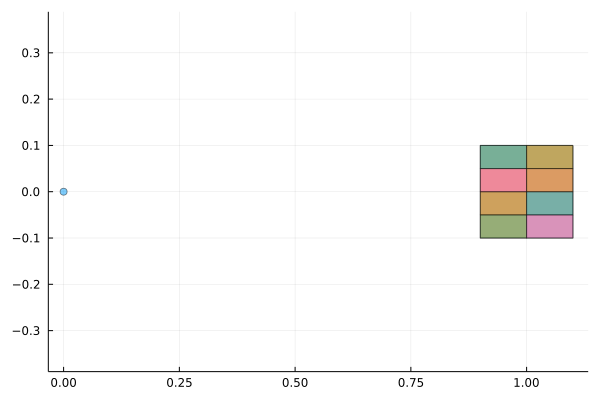

In [10]:
dvec = [2, 4] # division vector
Bsplit = split(B, dvec)
plot!(Bsplit)

## Symbolic Jacobians and Hessians

In [11]:
# for any box B, the objective function is the Taylor error

In [12]:
# vector of symbolic variables
x = [Num(SymbolicUtils.Sym{Real}(:x, i)) for i in 1:2]

2-element Vector{Num}:
 x₁
 x₂

Here we compute the symbolic expressions:

In [13]:
sys = @system(x' = lotkavolterra!(x), dim=2)

J = _jacobian_expression(sys, x)

2×2 Matrix{Num}:
  1.5 - x₂     -x₁
 x₂         x₁ - 3.0

In [14]:
J[1, 1]

1.5 - x₂

In [15]:
H = ReachabilityAnalysis._hessian_expression(sys, x)

H[1] # hessian with respect to the first component

2×2 Matrix{Num}:
  0  -1
 -1   0

In [16]:
H[2] # hessian with respect to the second component

2×2 Matrix{Num}:
 0  1
 1  0

We want to approximate the range of $H$.

## Symbolic-numeric linearization

We can alternatively use Symbolics.jl to build (compile) functions
that evaluate the Jacobian and Hessian. In other words, we get Julia function to evaluate these Jacobian / Hessian on given vectors.

In [17]:
fjac = ReachabilityAnalysis._jacobian_function(sys, x)

#421 (generic function with 1 method)

In [18]:
@time fjac([1.0, 10.0])

  0.038667 seconds (55.41 k allocations: 3.426 MiB, 99.91% compilation time)


2×2 Matrix{Float64}:
 -8.5  -1.0
 10.0  -2.0

In [19]:
fhes = ReachabilityAnalysis._hessian_function(sys, x)

2-element Vector{Function}:
 #423 (generic function with 1 method)
 #425 (generic function with 1 method)

In [20]:
fhes1 = fhes[1] # we have to specify the index

#423 (generic function with 1 method)

In [21]:
fhes1([1.0, 2.0])

2×2 Matrix{Int64}:
  0  -1
 -1   0

In [22]:
fhes1([1.0, 10.0])

2×2 Matrix{Int64}:
  0  -1
 -1   0

In [23]:
dint = [1.0 .. 1.0, 2.0 .. 2.0] # interval vector

2-element Vector{IntervalArithmetic.Interval{Float64}}:
 [1, 1]
 [2, 2]

In [24]:
fhes1(dint)

2×2 Matrix{Int64}:
  0  -1
 -1   0

In [25]:
H = fhes # use hessian function

2-element Vector{Function}:
 #423 (generic function with 1 method)
 #425 (generic function with 1 method)

In [26]:
# auxiliary functions needed because we are mixing intervals with sets
LazySets.center(B::IntervalBox) = mid.(B)
LazySets.radius_hyperrectangle(B::IntervalBox) = diam.(Bbox) ./ 2

function _translate(B::IntervalBox, p)
    return IntervalBox(B.v + p)
end

# overload the addition signs
Base.:(-)(B::IntervalBox, p) = _translate(B, -p)
Base.:(+)(B::IntervalBox, p) = _translate(B, p)

"""
    linearization_error(H, B::IntervalBox, p=center(B))

Compute the linearization error for a given box.

### Input

- `H` -- Hessian array of the vector field
- `B` -- domain of the expansion
- `p` -- (optional, default: `center(B)`) point at which we are taking the Taylor expansion

### Output

Interval box evaluating a range enclosure of the Lagrangian term of the vector field
whose Hessian is `H`.
"""
function linearization_error(H, B::IntervalBox, p=center(B))
    u = B.v     # vector of intervals
    w = u - p   # translation

    # evaluate Taylor's formula with Lagrange remainder using interval arithmetic
    R = [1/2 * w' * Hi(u) * w for Hi in H]

    return IntervalBox(R)
end

# auxiliary method using any hyperrectangle
function linearization_error(H, B::AbstractHyperrectangle, p=center(B))
    Bbox = convert(IntervalBox, B)
    return linearization_error(H, Bbox, p)
end

linearization_error (generic function with 4 methods)

In [27]:
H[1]

#423 (generic function with 1 method)

In [28]:
linearization_error(H, B) # uses the center of B by default

[-0.0100001, 0.0100001] × [-0.0100001, 0.0100001]

## Approximation using splitting directions

In [29]:
function linearization_error_div(H, B::IntervalBox, p=center(B), d=ones(dim(B)))

    u = B.v     # vector of intervals
    w = u - p   # translation
    w = w ./ d  # elementwise division

    R = [1/2 * w' * Hi(u) * w for Hi in H]

    return IntervalBox(R)
end

function linearization_error_div(H, B::AbstractHyperrectangle, p=center(B), d=ones(dim(B)))
    Bbox = convert(IntervalBox, B)
    return linearization_error_div(H, Bbox, p, d)
end

linearization_error_div (generic function with 6 methods)

In [30]:
d = [2, 4] # division vector

2-element Vector{Int64}:
 2
 4

In [31]:
linearization_error_div(H, B)

[-0.0100001, 0.0100001] × [-0.0100001, 0.0100001]

In [32]:
linearization_error_div(H, B, center(B), [2, 4])

[-0.00125001, 0.00125001] × [-0.00125001, 0.00125001]

In [33]:
linearization_error_div(H, B, center(B), [2, 10])

[-0.000500001, 0.000500001] × [-0.000500001, 0.000500001]

## Next steps

- optimization: finding a particular direction
- implement the intersection of unions